In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline



from sklearn.preprocessing import MinMaxScaler,StandardScaler

import metrics as metric
from tqdm import tqdm

c:\Users\gioel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\gioel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\gioel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Data loading

In [2]:
all_files=[]
import os
for root, dirs, files in os.walk("./data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]

## Data description and visualization

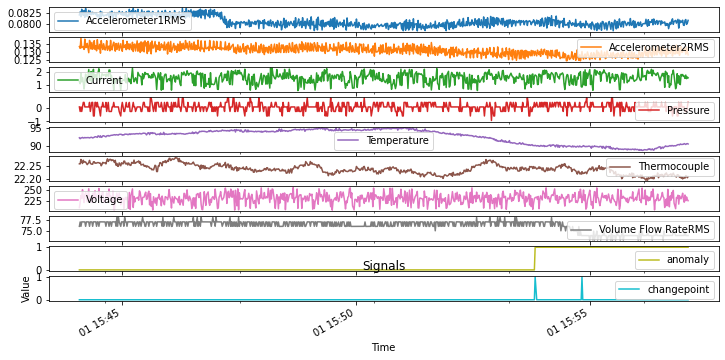

In [3]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6),subplots=True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Method applying

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda, Reshape
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras import losses
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import metrics

import numpy as np

from scipy.signal import medfilt

from tqdm import tqdm

from keras import backend as K

import warnings
warnings.filterwarnings("ignore")

In [5]:

#Redefine N_STEPS 3-6-12-24-48
N_STEPS = 6
WINDOW_SIZE=N_STEPS

latent_dim=64

def create_lstm_vae():

    x = Input(shape=(6, 8))

    # encoding
    h = LSTM(128,return_sequences=True)(x)
    h = LSTM(64)(h)

    # VAE Z layer
    z_mean = Dense(latent_dim, name='mean')(h)
    z_log_sigma = Dense(latent_dim, name='var')(h)
    
    def sampling(args):

        # we sample from the standard normal a matrix of batch_size * latent_size (taking into account minibatches)
        z_mean, z_log_sigma = args
        # sampling from Z~N(μ, σ^2) is the same as sampling from μ + σX, X~N(0,1)
        epsilon = K.random_normal(shape=(1, latent_dim),
                                  mean=0., stddev=1.)
                                  
        return z_mean + z_log_sigma * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_sigma])

    #decoding
    decoder= RepeatVector(N_STEPS)(z)
    decoder= LSTM(64, return_sequences=True)(decoder)
    decoder= LSTM(128, return_sequences=True)(decoder)
    
    x_decoded_mean= Dense(8)(decoder)
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, [z_mean, z_log_sigma, z], name='encoder')


    #decoder, from latent space to output
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = RepeatVector(N_STEPS)(decoder_input)
    _h_decoded = LSTM(64, return_sequences=True)(_h_decoded)
    _h_decoded= LSTM(128, return_sequences=True)(_h_decoded)
    x_decoded= Dense(8)(_h_decoded)

    dencoder = Model(decoder_input, x_decoded, name='dencoder')
 

    
    def vae_loss(x, x_decoded_mean):
        mse = losses.MeanSquaredError()
        xent_loss = mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss

        
        return loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    #vae.summary()

    return vae,encoder

In [6]:
def arch(data):

    BATCH_SIZE = 32
    
    model, encoder= create_lstm_vae()

    history = model.fit(
        data,
        data,
        epochs=600,
        batch_size=BATCH_SIZE,
        #validation_split=0.1,
        verbose=1
    )
    return history, model ,encoder

In [7]:
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

file

In [8]:


alpha=0.1
beta=1-alpha


import csv


header=['alpha','beta','F1','precision','recall','TP','TN','FP','FN']

with open(f'VAE_reEnc_{N_STEPS}.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    writer.writerow(header)

    for m in range(6,10):
        iterator=1
        TP=0
        TN=0
        FP=0
        FN=0
        for df in tqdm(list_of_df,desc='Loop'):

            #input and scale data
            train=df.drop(['anomaly','changepoint'], axis=1).values[:400]
            scaler = MinMaxScaler()
            train_scaled = scaler.fit_transform(train)
            X_train=create_sequences(train_scaled)

            model,encoder=create_lstm_vae()
            model.load_weights(filepath=f'MODEL_Saved/VAE/model_{iterator}_Win_{WINDOW_SIZE}.h5')
            encoder.load_weights(filepath=f'MODEL_Saved/VAE/encoder_{iterator}_Win_{WINDOW_SIZE}.h5')
            
            #TRAIN
            #Y_train = model.predict(X_train)

            #VALIDATION
            validation=df.drop(['anomaly','changepoint'], axis=1).values[400:450]

            X_val=scaler.transform(validation)
            X_val=create_sequences(X_val,N_STEPS)

            Y_val = model.predict(X_val)
            _,_,Z_val_2enc= encoder.predict(Y_val)
            _,_,Z_val_enc= encoder.predict(X_val)

            #TEST
            testing=df.drop(['anomaly','changepoint'], axis=1)

            X_test=scaler.transform(testing)
            X_test=create_sequences(X_test,N_STEPS)

            Y_test = model.predict(X_test)
            _,_,Z_test_2enc= encoder.predict(Y_test)
            _,_,Z_test_enc= encoder.predict(X_test)

            #ERROR
            mse=beta*np.mean(np.power(Z_val_2enc-Z_val_enc,2),axis=1)+alpha*np.mean(np.power(X_val-Y_val,2),axis=(1,2))
            mse=np.max(mse,axis=0)

            error_test=beta*np.mean(np.power(Z_test_2enc-Z_test_enc,2),axis=1)+alpha*np.mean(np.power(X_test-Y_test,2),axis=(1,2))

            outlier=error_test>mse

            predi=[False for j in range(len(df))]
            for i in range(len(df)-12):
                predi[i+11]=outlier[i]
            predi=np.array(predi)
            

            true_= df.anomaly>=1
            
            prediction_ =predi.astype(int)==1
            
            TP = TP+(true_ & prediction_).sum()   
            TN = TN+(~true_ & ~prediction_).sum()  
            FP = FP+(~true_ & prediction_).sum()    
            FN = FN+(true_ & ~prediction_).sum()    

            iterator=iterator+1


        
        PREC=TP / (TP + FP)
        REC = TP/ (TP+FN)
        f1=2 * PREC * REC/(PREC + REC)

        row=[alpha,beta,f1,PREC,REC,TP,TN,FP,FN]
        writer.writerow(row)

        beta=beta+0.1
        alpha=1-beta



Loop:  64%|██████▎   | 21/33 [03:23<01:56,  9.68s/it]


KeyboardInterrupt: 

score

In [10]:
iterator=1

for df in tqdm(list_of_df,desc='Loop'):

            #input and scale data
            train=df.drop(['anomaly','changepoint'], axis=1).values[:400]
            scaler = MinMaxScaler()
            train_scaled = scaler.fit_transform(train)
            X_train=create_sequences(train_scaled)

            model,encoder=create_lstm_vae()
            model.load_weights(filepath=f'MODEL_Saved/VAE/model_{iter}_Win_{WINDOW_SIZE}.h5')
            encoder.load_weights(filepath=f'MODEL_Saved/VAE/encoder_{iter}_Win_{WINDOW_SIZE}.h5')
            
            #TRAIN
            Y_train = model.predict(X_train)

            #VALIDATION
            validation=df.drop(['anomaly','changepoint'], axis=1).values[400:450]

            X_val=scaler.transform(validation)
            X_val=create_sequences(X_val,N_STEPS)

            Y_val = model.predict(X_val)
            _,_,Z_val_2enc= encoder.predict(Y_val)
            _,_,Z_val_enc= encoder.predict(X_val)

            #TEST
            testing=df.drop(['anomaly','changepoint'], axis=1)

            X_test=scaler.transform(testing)
            X_test=create_sequences(X_test,N_STEPS)

            Y_test = model.predict(X_test)
            _,_,Z_test_2enc= encoder.predict(Y_test)
            _,_,Z_test_enc= encoder.predict(X_test)

            #ERROR
            #mse=beta*np.mean(np.power(Z_val_2enc-Z_val_enc,2),axis=1)+alpha*np.mean(np.power(X_val-Y_val,2),axis=(1,2))
            score=np.mean(np.power(Z_val_2enc-Z_val_enc,2),axis=1)
            #np.save(f"./analisi_score/VAE_REenc/{iterator}.npy",score,allow_pickle=True)

            np.save(f"./VAE/{iterator}.npy",np.mean(np.power(X_test-Y_test,2),axis=(1,2)),allow_pickle=True)

            iterator=iterator+1

Loop: 100%|██████████| 33/33 [18:26<00:00, 33.53s/it]


In [11]:
MOD=[]
ENC=[]
for iterator in tqdm(range(1,34)):
    model,encoder=create_lstm_vae()
    model.load_weights(filepath=f'MODEL_Saved/VAE/model_{iter}_Win_{WINDOW_SIZE}.h5')
    encoder.load_weights(filepath=f'MODEL_Saved/VAE/encoder_{iter}_Win_{WINDOW_SIZE}.h5')
    MOD.append(model)
    ENC.append(encoder)

100%|██████████| 33/33 [04:51<00:00,  8.84s/it]


In [ ]:
WINDOW_SIZE=N_STEPS

import csv
header=['th_factor','method','F1','precision','recall','TP','TN','FP','FN']

mt=['IQR','MAD','STD']

with open('VAE_REenc.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    writer.writerow(header)
    thresholding_factor=[0.5,1,1.5,2]
    for k in range(3):
        for t in thresholding_factor:


            PREDICTION=[]
            TP=0
            TN=0
            FN=0
            FP=0
            iterator=1
            for df in tqdm(list_of_df):
                
                X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
                X_test = df.drop(['anomaly','changepoint'], axis=1)
                X_val = df[400:450].drop(['anomaly','changepoint'], axis=1)

                scaler = MinMaxScaler(feature_range=(0,1))
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled  = scaler.transform(X_test)
                X_val_scaled  = scaler.transform(X_val)

                X_train=create_sequences(X_train_scaled,WINDOW_SIZE)
                X_test_scaled=create_sequences(X_test_scaled,WINDOW_SIZE)
                X_val=create_sequences(X_val_scaled,WINDOW_SIZE)

                #model,encoder=create_lstm_vae()
                #model.load_weights(filepath=f'SKAB_MODEL/model_{iterator}_Win_{N_STEPS}.h5')
                #encoder.load_weights(filepath=f'SKAB_MODEL/encoder_{iterator}_Win_{N_STEPS}.h5')
                model=MOD[iterator-1]
                encoder=ENC[iterator-1]
                Y_val = model.predict(X_val)
                _,_,Z_val_2enc= encoder.predict(Y_val)
                _,_,Z_val_enc= encoder.predict(X_val)

                #TEST
                testing=df.drop(['anomaly','changepoint'], axis=1)

                X_test=scaler.transform(testing)
                X_test=create_sequences(X_test,N_STEPS)

                Y_test = model.predict(X_test)
                _,_,Z_test_2enc= encoder.predict(Y_test)
                _,_,Z_test_enc= encoder.predict(X_test)

                score=np.mean(np.power(Z_val_2enc-Z_val_enc,2),axis=1)

                if(k==2):
                    q1, q3 = np.percentile(score, 25), np.percentile(score, 75)
                    iqr = q3 - q1
                    th = q3 + t* iqr
                if(k==0):
                    median = np.median(score)
                    mad = 1.4826 * np.median(np.abs(score - median))
                    th = median + t * mad

                if(k==3):
                    mean, std = np.mean(score), np.std(score)
                    th = mean + t * std

                score=np.mean(np.power(Z_test_2enc-Z_test_enc,2),axis=1)
                score=score>th
                true_= df['anomaly'][WINDOW_SIZE-1:]>=1
                prediction_ = score[:].astype(int)==1

                TP = TP+(true_ & prediction_).sum()   
                TN = TN+(~true_ & ~prediction_).sum()  
                FP = FP+(~true_ & prediction_).sum()    
                FN = FN+(true_ & ~prediction_).sum()    

            PREC=TP / (TP + FP)
            REC = TP/ (TP+FN)
            f1=2 * PREC * REC/(PREC + REC)
            m=['IQR','MAD','STD']
            row=[t,mt[k],f1,PREC,REC,TP,TN,FP,FN]
            writer.writerow(row)

100%|██████████| 33/33 [00:32<00:00,  1.00it/s]


In [ ]:
WINDOW_SIZE=N_STEPS

import csv
header=['th_factor','method','F1','precision','recall','TP','TN','FP','FN']

mt=['IQR','MAD','STD']

with open('VAE.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    writer.writerow(header)
    thresholding_factor=[0.5,1,1.5,2]
    for k in range(3):
        for t in thresholding_factor:


            PREDICTION=[]
            TP=0
            TN=0
            FN=0
            FP=0
            iterator=1
            for df in tqdm(list_of_df):
                
                X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
                X_test = df.drop(['anomaly','changepoint'], axis=1)
                X_val = df[400:450].drop(['anomaly','changepoint'], axis=1)

                scaler = MinMaxScaler(feature_range=(0,1))
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled  = scaler.transform(X_test)
                X_val_scaled  = scaler.transform(X_val)

                X_train=create_sequences(X_train_scaled,WINDOW_SIZE)
                X_test_scaled=create_sequences(X_test_scaled,WINDOW_SIZE)
                X_val_scaled=create_sequences(X_val_scaled,WINDOW_SIZE)

                #model,encoder=create_lstm_vae()
                #model.load_weights(filepath=f'SKAB_MODEL/model_{iterator}_Win_{N_STEPS}.h5')
                model=MOD[iterator-1]
                encoder=ENC[iterator-1]
                Y_val=model.predict(X_val_scaled)

                score=np.mean(np.power(X_val_scaled - Y_val, 2), axis=(1,2))

                if(k==0):
                    q1, q3 = np.percentile(score, 25), np.percentile(score, 75)
                    iqr = q3 - q1
                    th = q3 + t* iqr
                if(k==1):
                    median = np.median(score)
                    mad = 1.4826 * np.median(np.abs(score - median))
                    th = median + t * mad

                if(k==2):
                    mean, std = np.mean(score), np.std(score)
                    th = mean + t * std


                Y_test=model.predict(X_test_scaled)
                score=np.mean(np.power(X_test_scaled - Y_test, 2), axis=(1,2))
                score=score>th
                true_= df['anomaly'][WINDOW_SIZE-1:]>=1
                prediction_ = score[:].astype(int)==1

                TP = TP+(true_ & prediction_).sum()   
                TN = TN+(~true_ & ~prediction_).sum()  
                FP = FP+(~true_ & prediction_).sum()    
                FN = FN+(true_ & ~prediction_).sum()    

            PREC=TP / (TP + FP)
            REC = TP/ (TP+FN)
            f1=2 * PREC * REC/(PREC + REC)
            m=['IQR','MAD','STD']
            row=[t,mt[k],f1,PREC,REC,TP,TN,FP,FN]
            writer.writerow(row)

100%|██████████| 33/33 [00:15<00:00,  2.11it/s]


In [13]:
iterator=1
WINDOW_SIZE=N_STEPS
for df in tqdm(list_of_df):
                
                X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
                X_test = df.drop(['anomaly','changepoint'], axis=1)
                X_val = df[400:450].drop(['anomaly','changepoint'], axis=1)

                scaler = MinMaxScaler(feature_range=(0,1))
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled  = scaler.transform(X_test)
                X_val_scaled  = scaler.transform(X_val)

                X_train=create_sequences(X_train_scaled,WINDOW_SIZE)
                X_test_scaled=create_sequences(X_test_scaled,WINDOW_SIZE)
                X_val=create_sequences(X_val_scaled,WINDOW_SIZE)


                model=MOD[iterator-1]
                encoder=ENC[iterator-1]
                Y_val = model.predict(X_val)
                _,_,Z_val_2enc= encoder.predict(Y_val)
                _,_,Z_val_enc= encoder.predict(X_val)

                #TEST
                testing=df.drop(['anomaly','changepoint'], axis=1)

                X_test=scaler.transform(testing)
                X_test=create_sequences(X_test,N_STEPS)

                Y_test = model.predict(X_test)
                _,_,Z_test_2enc= encoder.predict(Y_test)
                _,_,Z_test_enc= encoder.predict(X_test)



                score=np.mean(np.power(Z_test_2enc-Z_test_enc,2),axis=1)

                np.savetxt(f'./SCORE/REENC/{iterator}.csv', score, delimiter=',')
                iterator=iterator+1



100%|██████████| 33/33 [10:16<00:00, 18.67s/it]
